<a href="https://colab.research.google.com/github/mitali-dxt/PathRefiner/blob/master/implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Error fitting ellipse: 'EllipseModel' object has no attribute 'fit'
line_prob: 0, circle_prob: 0.6334203580990195, rectangle_prob: 0, square_prob: 0, star_prob: 0, ellipse_prob: 0, saturn_ring_prob: 0
Error fitting ellipse: 'EllipseModel' object has no attribute 'fit'
line_prob: 0, circle_prob: 0.6840545610831403, rectangle_prob: 0, square_prob: 0, star_prob: 0, ellipse_prob: 0, saturn_ring_prob: 0
Error fitting ellipse: 'EllipseModel' object has no attribute 'fit'
line_prob: 0, circle_prob: 0.7477232119023417, rectangle_prob: 0, square_prob: 0, star_prob: 0, ellipse_prob: 0, saturn_ring_prob: 0
Error fitting ellipse: 'EllipseModel' object has no attribute 'fit'
line_prob: 0, circle_prob: 0.5281000559816261, rectangle_prob: 0, square_prob: 0, star_prob: 0, ellipse_prob: 0, saturn_ring_prob: 0
Error fitting ellipse: 'EllipseModel' object has no attribute 'fit'
line_prob: 0, circle_prob: 0.10166855492832308, rectangle_prob: 0, square_prob: 0, star_prob: 0, ellipse_prob: 0, saturn_ring_pr

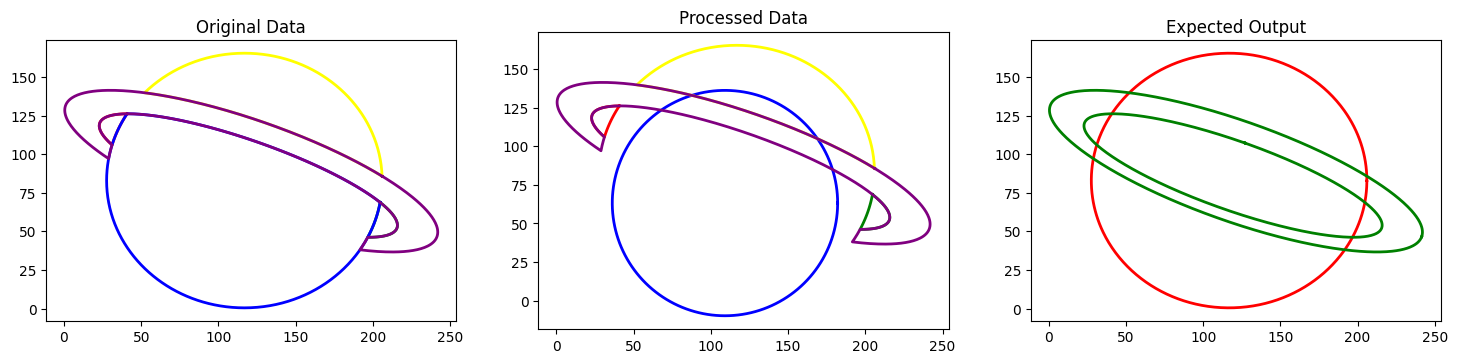

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from scipy.optimize import least_squares
from sklearn.preprocessing import PolynomialFeatures
from skimage.measure import EllipseModel
import cv2

def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def regularize_line(points):
    if len(points) < 2:
        return points
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    return np.column_stack((X, y_pred))

def regularize_circle(points):
    if len(points) < 3:
        return points
    def calc_R(xc, yc):
        return np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)
    def residuals(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    center_estimate = np.mean(points, axis=0)
    center = least_squares(residuals, center_estimate).x
    Ri = calc_R(*center)
    R = Ri.mean()
    theta = np.linspace(0, 2 * np.pi, len(points))
    x_fit = center[0] + R * np.cos(theta)
    y_fit = center[1] + R * np.sin(theta)
    return np.column_stack((x_fit, y_fit))

def regularize_rectangle(points):
    if len(points) < 4:
        return points
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    rect_points = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max], [x_min, y_min]])
    return rect_points

def regularize_square(points):
    if len(points) < 4:
        return points
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    side = max(x_max - x_min, y_max - y_min)
    sqr_points = np.array([[x_min, y_min], [x_min + side, y_min], [x_min + side, y_min + side], [x_min, y_min + side], [x_min, y_min]])
    return sqr_points

def regularize_star(points):
    if len(points) < 5:
        return points
    center = np.mean(points, axis=0)
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    sorted_points = points[np.argsort(angles)]
    return sorted_points

def regularize_ellipse(points):
    if len(points) < 5:
        return points

    def fit_ellipse(points):
        # Fit an ellipse using a polynomial approach
        X = points[:, 0]
        Y = points[:, 1]

        # Create a polynomial feature for x^2, y^2, and xy
        poly = PolynomialFeatures(degree=2)
        X_poly = poly.fit_transform(np.column_stack((X, Y)))

        # Fit a linear regression model
        model = LinearRegression().fit(X_poly, np.ones(len(X)))

        # Extract ellipse parameters
        a, b, c, d, e, f = model.coef_

        # Compute ellipse parameters (e.g., center, axes, angle) from the fitted coefficients
        return a, b, c, d, e, f

    a, b, c, d, e, f = fit_ellipse(points)

    # Generate ellipse points using the parameters
    theta = np.linspace(0, 2 * np.pi, len(points))
    x_fit = np.cos(theta)  # Replace with actual ellipse formula
    y_fit = np.sin(theta)  # Replace with actual ellipse formula

    return np.column_stack((x_fit, y_fit))
def regularize_saturn_ring(points):
    if len(points) < 10:
        return points

    # Fit the main ellipse for Saturn's body
    body_ellipse = regularize_ellipse(points)

    # Generate additional rings
    num_rings = 3
    ring_width = 0.1
    ring_ellipses = []
    for i in range(num_rings):
        scale = 1 + i * ring_width
        ring_ellipse = body_ellipse * scale
        ring_ellipses.append(ring_ellipse)

    return np.vstack([body_ellipse] + ring_ellipses)

def get_contour(points):
    points = points.reshape((-1, 1, 2)).astype(np.int32)
    contour = cv2.approxPolyDP(points, 0.02 * cv2.arcLength(points, True), True)
    return contour

def similarity_line(points):
    if len(points) < 2:
        return 0
    contour = get_contour(points)
    return 1 if len(contour) == 2 else 0

def similarity_circle(points):
    if len(points) < 3:
        return 0
    contour = get_contour(points)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = 4 * np.pi * (area / (perimeter * perimeter))
    return circularity

def similarity_rectangle(points):
    if len(points) < 4:
        return 0
    contour = get_contour(points)
    if len(contour) == 4:
        return 1
    return 0

def similarity_square(points):
    if len(points) < 4:
        return 0

    # Convert points to a contour format
    contour = np.array(points, dtype=np.int32).reshape((-1, 1, 2))

    # Ensure the contour is properly closed and simplified
    contour = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)

    if len(contour) != 4:
        return 0

    # Compute bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)

    # Compute aspect ratio to check if the shape is a square
    aspect_ratio = w / float(h)

    # Check if aspect ratio is close to 1 (indicating a square)
    if 0.9 <= aspect_ratio <= 1.1:
        return 1

    return 0


def similarity_star(points):
    if len(points) < 5:
        return 0

    contour = np.array(points, dtype=np.int32).reshape((-1, 1, 2))
    # Ensure the contour is properly closed and simplified
    contour = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
    hull = cv2.convexHull(contour, returnPoints=False)

    # Ensure we have convexity defects before proceeding
    if hull.size == 0:
        return 0

    try:
        defects = cv2.convexityDefects(contour, hull)
        if defects is None:
            return 0

        num_defects = 0
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            start = tuple(contour[s][0])
            end = tuple(contour[e][0])
            far = tuple(contour[f][0])
            a = np.linalg.norm(np.array(start) - np.array(end))
            b = np.linalg.norm(np.array(start) - np.array(far))
            c = np.linalg.norm(np.array(end) - np.array(far))
            angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))
            if angle <= np.pi / 2:  # angle less than 90 degrees
                num_defects += 1

        return 1 if num_defects == 5 else 0

    except cv2.error as e:
        print(f"OpenCV error: {e}")
        return 0

def similarity_ellipse(points):
    if len(points) < 5:
        return 0

    # Fit an ellipse to the points
    try:
        ellipse_model = EllipseModel()
        ellipse_model.fit(points)
        ellipse_params = ellipse_model.params  # Ellipse parameters: [x0, y0, a, b, theta]

        # Generate ellipse points using the fitted parameters
        theta = np.linspace(0, 2 * np.pi, len(points))
        x_fit = ellipse_params[0] + ellipse_params[2] * np.cos(theta) * np.cos(ellipse_params[4]) - ellipse_params[3] * np.sin(theta) * np.sin(ellipse_params[4])
        y_fit = ellipse_params[1] + ellipse_params[2] * np.cos(theta) * np.sin(ellipse_params[4]) + ellipse_params[3] * np.sin(theta) * np.cos(ellipse_params[4])
        ellipse_fit = np.column_stack((x_fit, y_fit))

        # Compute the fitting error
        distances = np.linalg.norm(points[:, None] - ellipse_fit[None, :], axis=2)
        min_distances = np.min(distances, axis=1)
        error = np.mean(min_distances)

        # Define a threshold for similarity (this may need adjustment)
        threshold = 5  # Adjust based on your requirements
        return 1 if error < threshold else 0

    except Exception as e:
        print(f"Error fitting ellipse: {e}")
        return 0

def similarity_saturn_ring(points):
    if len(points) < 10:
        return 0

    # Fit the main ellipse for Saturn's body
    main_ellipse = regularize_ellipse(points)

    # Fit additional rings
    try:
        num_rings = 3
        ring_width = 0.1
        rings = []
        for i in range(num_rings):
            scale = 1 + i * ring_width
            ring_ellipse = regularize_ellipse(points) * scale
            rings.append(ring_ellipse)

        # Calculate the fitting error for each ring
        errors = []
        for ring in rings:
            distances = np.linalg.norm(points[:, None] - ring[None, :], axis=2)
            min_distances = np.min(distances, axis=1)
            error = np.mean(min_distances)
            errors.append(error)

        # Combine errors to assess overall similarity (may need adjustment)
        overall_error = np.mean(errors)
        threshold = 10  # Adjust based on your requirements
        return 1 if overall_error < threshold else 0

    except Exception as e:
        print(f"Error fitting Saturn rings: {e}")
        return 0


def find_nearest_curve(curves, point):
    """Find the nearest curve to a given point."""
    min_dist = float('inf')
    nearest_curve = None
    for curve in curves:
        for p in curve:
            dist = np.linalg.norm(np.array(p) - np.array(point))
            if dist < min_dist:
                min_dist = dist
                nearest_curve = curve
    return nearest_curve

def interpolate_gap(start_point, end_point, num_points=10):
    """Interpolate a gap between two points."""
    x = [start_point[0], end_point[0]]
    y = [start_point[1], end_point[1]]
    f = interp1d(x, y, kind='linear')
    x_new = np.linspace(start_point[0], end_point[0], num_points)
    y_new = f(x_new)
    return np.column_stack((x_new, y_new))

def complete_curve(curve, all_curves):
    """Complete a curve with gaps."""
    completed_curve = []
    for i in range(len(curve) - 1):
        start_point = curve[i]
        end_point = curve[i + 1]
        # Assume if there's a gap if the next point is far away
        if np.linalg.norm(np.array(end_point) - np.array(start_point)) > 1.0:
            nearest_curve = find_nearest_curve(all_curves, start_point)
            if nearest_curve is not None:
                # Interpolate gap using nearest curve information
                gap_points = interpolate_gap(start_point, end_point)
                completed_curve.append(gap_points)
        completed_curve.append([start_point, end_point])
    return np.vstack(completed_curve)


def process_shapes(paths_XYs, threshold=0.7):
    processed_paths = []
    for path in paths_XYs:
        for points in path:
            if len(points) < 2:
                continue

            # Calculate similarity probabilities for different shapes
            line_prob = similarity_line(points)
            circle_prob = similarity_circle(points)
            rectangle_prob = similarity_rectangle(points)
            square_prob = similarity_square(points)
            star_prob = similarity_star(points)
            ellipse_prob = similarity_ellipse(points)
            saturn_ring_prob = similarity_saturn_ring(points)

            # Determine the maximum similarity probability
            max_prob = max(line_prob, circle_prob, rectangle_prob, square_prob, star_prob, ellipse_prob, saturn_ring_prob)

            print(f"line_prob: {line_prob}, circle_prob: {circle_prob}, rectangle_prob: {rectangle_prob}, square_prob: {square_prob}, star_prob: {star_prob}, ellipse_prob: {ellipse_prob}, saturn_ring_prob: {saturn_ring_prob}")

            # Regularize the shape based on the highest similarity probability
            if max_prob < threshold:
                # If the shape does not closely match any regular shape, keep it as is
                processed_paths.append([points])
            elif max_prob == line_prob:
                processed_paths.append([regularize_line(points)])
            elif max_prob == circle_prob:
                processed_paths.append([regularize_circle(points)])
            elif max_prob == rectangle_prob:
                processed_paths.append([regularize_rectangle(points)])
            elif max_prob == square_prob:
                processed_paths.append([regularize_square(points)])
            elif max_prob == star_prob:
                processed_paths.append([regularize_star(points)])
            elif max_prob == ellipse_prob:
                processed_paths.append([regularize_ellipse(points)])
            elif max_prob == saturn_ring_prob:
                processed_paths.append([regularize_saturn_ring(points)])
    return processed_paths

def plot(paths_XYs, title, ax):
    colours = ['red', 'green', 'blue', 'yellow', 'purple', 'cyan', 'magenta']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(title)


csv_path1 = "occlusion2.csv"
csv_path2 = "occlusion2_sol.csv"

output_data1 = read_csv_(csv_path1)
expected_output_data = read_csv_(csv_path2)

processed_data = process_shapes(output_data1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

plot(output_data1, "Original Data", ax1)
plot(processed_data, "Processed Data", ax2)
plot(expected_output_data, "Expected Output", ax3)

plt.show()